## Overfitting analysis based on segment ratio 

When a machine learning model fails to genralize effectively from training data to new, unseen data, it is referred to as overfitting.

<table style="border: none;">
  <tr>
    <td style="border: none;"><img src="images/classification.png" width="200"/></td>
    <td style="border: none;"><img src="images/regression.png" width="200"/></td>
  </tr>
  <tr>
    <td style="text-align:center; border: none">a. Classification</td>
    <td style="text-align:center; border: none">b. Regression</td>
  </tr>
</table>
Fig. 1: Overfitting in classification and Regression: Models capturing noise instead of generatl patterns.

##### Overfitting Detection process

1. Training vs. Validation Performance Comparison
  - Overfitting can be identified by comparing training and testing validation loss.
  - Sign of Overfitting High accuracy on training data but significantly lower accuracy on validation data.
2. Cross validation
  - Using k-fold cross-validation to evaluate the model on multiple subsets of dataset.
  - Sign of overfitting: Large performance variation across different folds.

A model's ability to handle small variations in samples can be evaluated by subdividing the dataset into small clusters of same class. By testing the models predictions on unseen clusters, we can gain deeper into its generalization capacity.

##### Mini-cluster overfitting crirerion:

is_overfitting, n = correct segment / wrong segment 

   - If the ratio is less than 1, the model is overfitting
   - If the ratio is greater than 1, the model generalize well to unseen clusters

##### Process:
1. Split the data into train and split.
2. Calculate the train and test accuraycy
3. Segment the data into mini clusters (Using Decision Tree classifier).
3. Check the segment that only appears on test split
4. Check if the model is overfitting by checking the test only segments.
5. Run this for 50 times on random selection of samples for a particular split generate a density plot on this.



In [2]:
# Synthetic datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))

def generate_two_dimensional_data(num_samples_per_class):
    """Generate two dimentional data set for multiple classes"""
    np.random.seed(0)  

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]] 
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [-2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]] 
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['class'] = labels

    return df

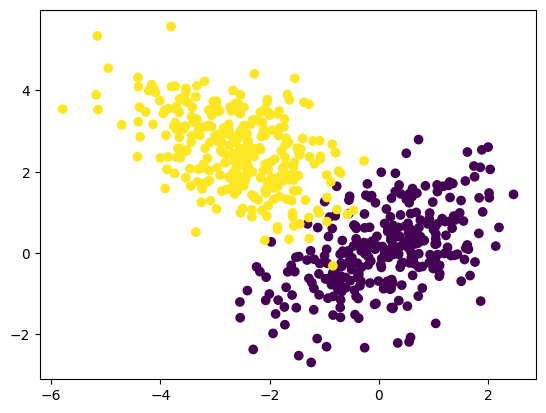

In [3]:
# visualisation of two dimensional dataset
df = generate_two_dimensional_data(300)

plt.scatter(df['x1'], df['x2'], c=df['class'], cmap="viridis")
plt.show()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings

# Function to segment the data using Decision Tree
def segmentation(X, y, verbose=True):
    clf = DecisionTreeClassifier(max_depth=None, random_state=42)
    clf.fit(X, y)
    training_accuracy = clf.score(X, y)
    if verbose:
        print(f"Decision Tree training accuracy: {training_accuracy * 100:.2f}%")

    def get_rectangles_from_tree(tree):
        left = tree.children_left
        right = tree.children_right
        threshold = tree.threshold
        feature = tree.feature
        value = tree.value

        def recurse(node, bounds):
            # Leaf node: return the rectangle and its predicted label.
            if feature[node] == _tree.TREE_UNDEFINED:
                leaf_label = np.argmax(value[node][0])
                return [(bounds, leaf_label)]
            
            # Copy bounds for left and right children
            new_bounds_left = [list(b) for b in bounds]
            new_bounds_right = [list(b) for b in bounds]
            
            feature_index = feature[node]
            threshold_value = threshold[node]
            
            # Update bounds for left (<= threshold) and right (> threshold) splits
            new_bounds_left[feature_index][1] = threshold_value
            new_bounds_right[feature_index][0] = threshold_value
            
            left_rectangles = recurse(left[node], new_bounds_left)
            right_rectangles = recurse(right[node], new_bounds_right)
            
            return left_rectangles + right_rectangles

        # Initialize bounds for each feature as (-infty, infty)
        initial_bounds = [[-np.inf, np.inf] for _ in range(tree.n_features)]
        rectangles = recurse(0, initial_bounds)
        return rectangles

    rectangles = get_rectangles_from_tree(clf.tree_)
    if verbose:
        print(f"Total mini clusters (rectangles) extracted: {len(rectangles)}")
    return rectangles

# Main function to check overfitting
def is_overfitting(df, classifier_name, test_size=0.2, random_state=42, verbose=True):
    # Task 1: Split the data into training and testing sets
    X = df.drop(columns=['class'])
    y = df['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    classifier = get_classifier(classifier_name)
    classifier.fit(X_train, y_train)
    # train accuracy
    y_train_pred = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    if verbose:
        print(f"train_Accuracy: {train_accuracy:.2f}")
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if verbose:
        print(f"test_Accuracy: {accuracy:.2f}")

    # Task 2: Segment the data into mini clusters
    rectangles = segmentation(X, y, verbose=verbose)

    # Task 3: Check the rectangles that only appear in the test split
    X_train_arr = X_train.values
    X_test_arr = X_test.values
    y_test_arr = y_test.values
    
    test_only_segments = []

    for rect, label in rectangles:
        rect = np.array(rect)
        # Check if any training sample falls in this rectangle, skip if yes
        train_in_rect = np.all((X_train_arr >= rect[:, 0]) & (X_train_arr <= rect[:, 1]), axis=1)
        if np.any(train_in_rect):
            continue
        
        # Check if any test sample falls in this rectangle, segments without any samples are ignored
        test_in_rect = np.all((X_test_arr >= rect[:, 0]) & (X_test_arr <= rect[:, 1]), axis=1)
        if not np.any(test_in_rect):
            continue
            
        test_only_segments.append((rect, label))
    
    # Task 4: Check if the model is overfitting by checking the test only segments 
    correct_segments = []
    wrong_segments = []
    correct_samples = 0
    wrong_samples = 0

    # Suppress the sklearn warning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="X does not have valid feature names")
        
        for rect, seg_label in test_only_segments:
            lower_bounds = rect[:, 0]
            upper_bounds = rect[:, 1]
            mask = np.all((X_test_arr >= lower_bounds) & (X_test_arr <= upper_bounds), axis=1)

            segment_samples = X_test_arr[mask]
            num_samples = len(segment_samples)
            preds = classifier.predict(segment_samples)

            # Check if all predictions match the segment label
            if np.all(preds == seg_label):
                correct_segments.append((rect, seg_label))
                correct_samples += num_samples
            else:
                wrong_segments.append((rect, seg_label))
                wrong_samples += num_samples

    if verbose:
        print(f"\n--- Test-Only Segments Analysis ---")
        print(f"Total test-only segments: {len(test_only_segments)}")
        print(f"Correct segments: {len(correct_segments)}")
        print(f"Wrong segments: {len(wrong_segments)}")
        print(f"Correct samples: {correct_samples}")
        print(f"Wrong samples: {wrong_samples}")
    
    return {
        'total_mini_clusters': len(rectangles),
        'train_accuracy': train_accuracy,
        'test_accuracy': accuracy,
        'correct_segments': len(correct_segments),
        'wrong_segments': len(wrong_segments),
        'correct_samples': correct_samples,
        'wrong_samples': wrong_samples,
        'total_test_only_segments': len(test_only_segments)
    }

# function to select classifier
def get_classifier(classifier_name):
    if classifier_name == "GaussianNB":
        return GaussianNB()
    elif classifier_name == "LR":
        return LogisticRegression(max_iter=1000, random_state=42)
    elif classifier_name == "SVM":
        return SVC(random_state=42)
    elif classifier_name == "RF":
        return RandomForestClassifier(random_state=42)

In [5]:
# test on synthetic dataset
results = is_overfitting(df, classifier_name="GaussianNB", test_size=0.4)
overfitting_info_segments = "Not Overfitting" if (results['correct_segments']/ results['wrong_segments'] > 1) else "Overfitting"
overfitting_info_samples = "Not Overfitting" if (results['correct_samples']/ results['wrong_samples'] > 1) else "Overfitting"
print("Overfitting Analysis on Synthetic Dataset (segment_wise):", overfitting_info_segments)
print("Overfitting Analysis on Synthetic Dataset (sample_wise):", overfitting_info_samples)

train_Accuracy: 0.97
test_Accuracy: 0.95
Decision Tree training accuracy: 100.00%
Total mini clusters (rectangles) extracted: 20

--- Test-Only Segments Analysis ---
Total test-only segments: 5
Correct segments: 2
Wrong segments: 3
Correct samples: 2
Wrong samples: 4
Overfitting Analysis on Synthetic Dataset (segment_wise): Overfitting
Overfitting Analysis on Synthetic Dataset (sample_wise): Overfitting


In [6]:
# test on Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target 
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['class'] = y
results = is_overfitting(iris_df, classifier_name='GaussianNB', test_size=0.6)
overfitting_info_segments = "Not Overfitting" if (results['correct_segments']/ results['wrong_segments'] > 1) else "Overfitting"
overfitting_info_samples = "Not Overfitting" if (results['correct_samples']/ results['wrong_samples'] > 1) else "Overfitting"
print("Overfitting Analysis on Iris Dataset (segment_wise):", overfitting_info_segments)
print("Overfitting Analysis on Iris Dataset (sample_wise):", overfitting_info_samples)

train_Accuracy: 0.93
test_Accuracy: 0.96
Decision Tree training accuracy: 100.00%
Total mini clusters (rectangles) extracted: 9

--- Test-Only Segments Analysis ---
Total test-only segments: 1
Correct segments: 0
Wrong segments: 1
Correct samples: 0
Wrong samples: 1
Overfitting Analysis on Iris Dataset (segment_wise): Overfitting
Overfitting Analysis on Iris Dataset (sample_wise): Overfitting


In [7]:
# testing wine quality dataset
from sklearn.preprocessing import LabelEncoder
df_wine = pd.read_csv("../data/continuous/winequality-red.csv", sep= ";")
df_wine.rename(columns={'quality': 'class'}, inplace=True)
label_encoder = LabelEncoder()
df_wine['class'] = label_encoder.fit_transform(df_wine['class'])
results = is_overfitting(df_wine, classifier_name="GaussianNB", test_size=0.3, verbose=True)
overfitting_info_segments = "Not Overfitting" if (results['correct_segments']/ results['wrong_segments'] > 1) else "Overfitting"
overfitting_info_samples = "Not Overfitting" if (results['correct_samples']/ results['wrong_samples'] > 1) else "Overfitting"
print("Overfitting Analysis on wine-quality Dataset (segment_wise):", overfitting_info_segments)
print("Overfitting Analysis on wine-quality Dataset (sample_wise):", overfitting_info_samples)

train_Accuracy: 0.57
test_Accuracy: 0.54
Decision Tree training accuracy: 100.00%
Total mini clusters (rectangles) extracted: 401

--- Test-Only Segments Analysis ---
Total test-only segments: 68
Correct segments: 21
Wrong segments: 47
Correct samples: 28
Wrong samples: 54
Overfitting Analysis on wine-quality Dataset (segment_wise): Overfitting
Overfitting Analysis on wine-quality Dataset (sample_wise): Overfitting


In [8]:
# ran tests for multiple test sizes and plot the segment ratios and sample ratios
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_overfitting_across_test_sizes(df, classifier_name="GaussianNB"):
    test_sizes = [0.2, 0.3, 0.4, 0.5, 0.6]
    colors = ['blue', 'orange', 'green', 'purple', 'brown']

    # Store results for each test size
    all_segment_ratios = {}
    all_sample_ratios = {}

    for test_size in test_sizes:
        correct_segments = []
        wrong_segments = []
        correct_samples = []
        wrong_samples = []
        test_accuracies = []
        train_accuracies = []
        segment_ratios = []
        sample_ratios = []
        
        for i in range(100):
            results = is_overfitting(df, classifier_name=classifier_name, test_size=test_size, random_state=None, verbose=False)
            if results['wrong_segments'] == 0:
                continue  # avoid division by zero
            test_accuracies.append(results['test_accuracy'])
            train_accuracies.append(results['train_accuracy'])
            correct_segments.append(results['correct_segments'])
            wrong_segments.append(results['wrong_segments'])
            correct_samples.append(results['correct_samples'])
            wrong_samples.append(results['wrong_samples'])
            segment_ratio = results['correct_segments'] / results['wrong_segments']
            sample_ratio = results['correct_samples'] / results['wrong_samples']
            segment_ratios.append(segment_ratio)
            sample_ratios.append(sample_ratio)

        
        all_segment_ratios[test_size] = segment_ratios
        all_sample_ratios[test_size] = sample_ratios

        overfitting_info_segments = "Not Overfitting" if (np.mean(segment_ratios) > 1) else "Overfitting"
        overfitting_info_samples = "Not Overfitting" if (np.mean(sample_ratios) > 1) else "Overfitting"

        print(f"\nTest Size: {test_size}")
        print(f"Average Train Accuracy: {np.mean(train_accuracies):.4f}")
        print(f"Average Test Accuracy: {np.mean(test_accuracies):.4f}")
        print(f"Average Correct Segments: {np.mean(correct_segments):.2f}")
        print(f"Average Wrong Segments: {np.mean(wrong_segments):.2f}")
        print(f"Average Correct Samples: {np.mean(correct_samples):.2f}")
        print(f"Average Wrong Samples: {np.mean(wrong_samples):.2f}")
        print(f"Average Segment Ratio: {np.mean(segment_ratios):.4f}")
        print(f"Average Sample Ratio: {np.mean(sample_ratios):.4f}")
        print("Overfitting Analysis on Dataset (segment_wise):", overfitting_info_segments)
        print("Overfitting Analysis on Dataset (sample_wise):", overfitting_info_samples)

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot 1: Segment Ratios Density
    for i, test_size in enumerate(test_sizes):
        sns.kdeplot(all_segment_ratios[test_size], fill=True, ax=axes[0], 
                    color=colors[i], alpha=0.4, label=f'Test Size: {test_size}')
        avg = np.mean(all_segment_ratios[test_size])
        axes[0].axvline(avg, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.7)

    axes[0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Threshold: 1.0')
    axes[0].set_xlabel('Segment Ratio (Correct/Wrong)', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title('Density Plot of Segment Ratios', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Sample Ratios Density
    for i, test_size in enumerate(test_sizes):
        sns.kdeplot(all_sample_ratios[test_size], fill=True, ax=axes[1], 
                    color=colors[i], alpha=0.4, label=f'Test Size: {test_size}')
        avg = np.mean(all_sample_ratios[test_size])
        axes[1].axvline(avg, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.7)

    axes[1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Threshold: 1.0')
    axes[1].set_xlabel('Sample Ratio (Correct/Wrong)', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title('Density Plot of Sample Ratios', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Test Size: 0.2
Average Train Accuracy: 0.9694
Average Test Accuracy: 0.9615
Average Correct Segments: 0.71
Average Wrong Segments: 1.34
Average Correct Samples: 0.74
Average Wrong Samples: 1.44
Average Segment Ratio: 0.5929
Average Sample Ratio: 0.6024
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.3
Average Train Accuracy: 0.9695
Average Test Accuracy: 0.9632
Average Correct Segments: 1.18
Average Wrong Segments: 1.67
Average Correct Samples: 1.42
Average Wrong Samples: 1.89
Average Segment Ratio: 0.8441
Average Sample Ratio: 0.9312
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.4
Average Train Accuracy: 0.9693
Average Test Accuracy: 0.9650
Average Correct Segments: 1.69
Average Wrong Segments: 2.13
Average Correct Samples: 2.25
Average Wrong Samples: 2.52
Average Segment Ratio: 1.0201
Average Sample Ratio: 1.3061


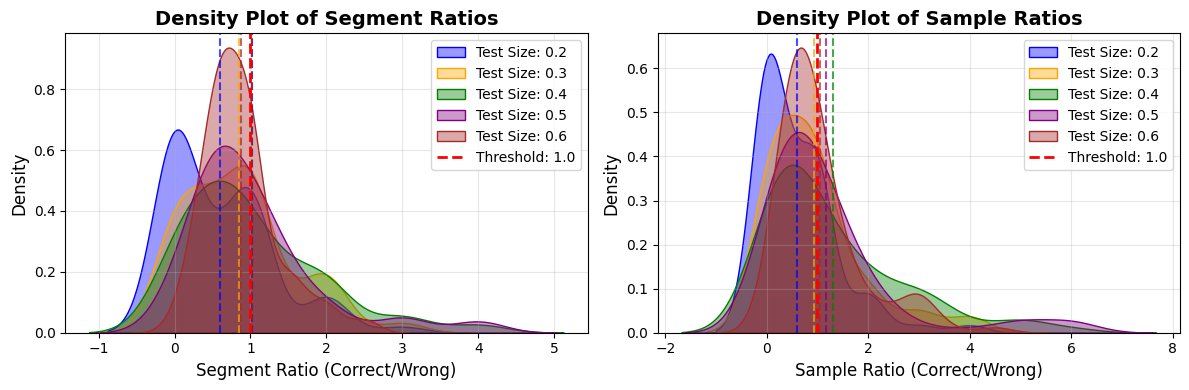

In [9]:
# Test on synthetic dataset or other datasets.
analyze_overfitting_across_test_sizes(df, classifier_name="GaussianNB")


Test Size: 0.2
Average Train Accuracy: 0.9625
Average Test Accuracy: 0.9333
Average Correct Segments: 0.17
Average Wrong Segments: 1.17
Average Correct Samples: 0.17
Average Wrong Samples: 1.33
Average Segment Ratio: 0.1667
Average Sample Ratio: 0.1389
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.3
Average Train Accuracy: 0.9645
Average Test Accuracy: 0.9397
Average Correct Segments: 0.41
Average Wrong Segments: 1.31
Average Correct Samples: 0.49
Average Wrong Samples: 1.53
Average Segment Ratio: 0.3305
Average Sample Ratio: 0.3729
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.4
Average Train Accuracy: 0.9620
Average Test Accuracy: 0.9465
Average Correct Segments: 0.49
Average Wrong Segments: 1.39
Average Correct Samples: 0.62
Average Wrong Samples: 1.65
Average Segment Ratio: 0.3935
Average Sample Ratio: 0.4856


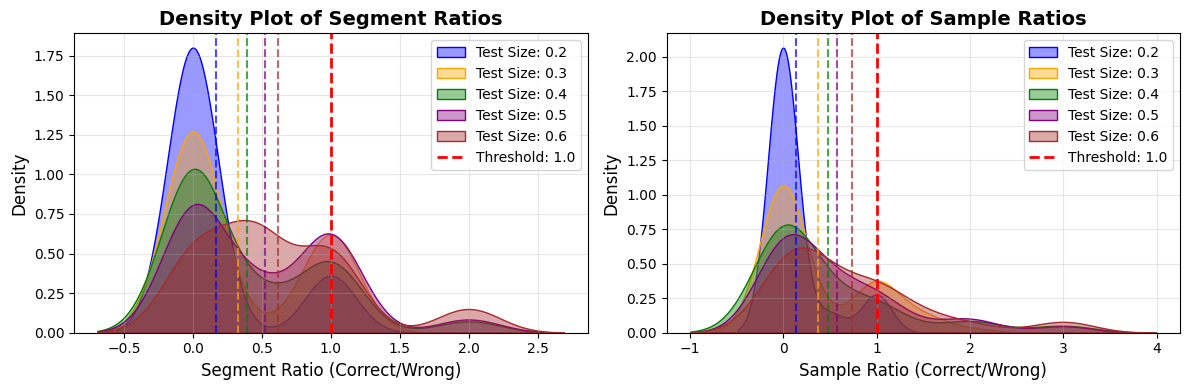

In [11]:
# -------------testing the iris dataset------------
analyze_overfitting_across_test_sizes(iris_df, classifier_name="GaussianNB")


Test Size: 0.2
Average Train Accuracy: 0.5657
Average Test Accuracy: 0.5454
Average Correct Segments: 11.03
Average Wrong Segments: 28.27
Average Correct Samples: 11.65
Average Wrong Samples: 30.65
Average Segment Ratio: 0.4030
Average Sample Ratio: 0.3925
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.3
Average Train Accuracy: 0.5620
Average Test Accuracy: 0.5430
Average Correct Segments: 17.61
Average Wrong Segments: 44.30
Average Correct Samples: 19.53
Average Wrong Samples: 50.84
Average Segment Ratio: 0.4071
Average Sample Ratio: 0.3946
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.4
Average Train Accuracy: 0.5594
Average Test Accuracy: 0.5332
Average Correct Segments: 24.34
Average Wrong Segments: 63.39
Average Correct Samples: 27.89
Average Wrong Samples: 77.15
Average Segment Ratio: 0.3903
Average Sample Ra

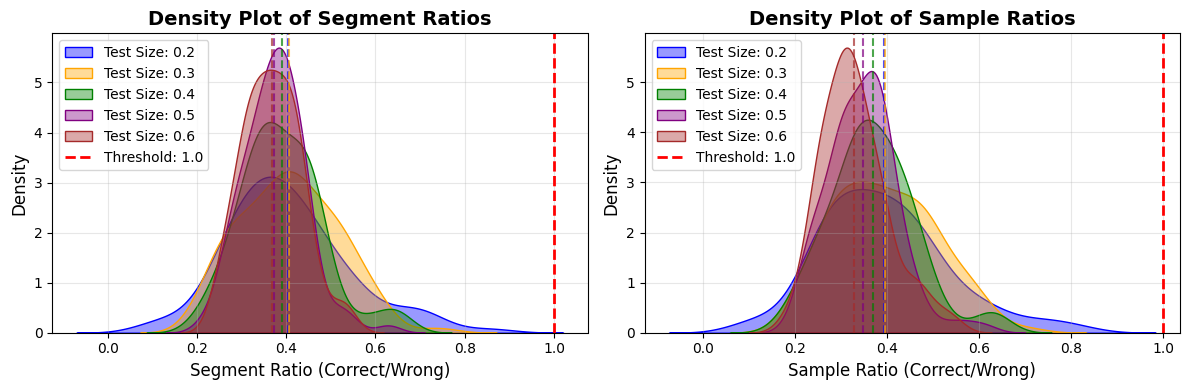

In [12]:
# ------------------testing wine quality dataset------------------
analyze_overfitting_across_test_sizes(df_wine, classifier_name="GaussianNB")


Test Size: 0.2
Average Train Accuracy: 0.7640
Average Test Accuracy: 0.7643
Average Correct Segments: 22.13
Average Wrong Segments: 62.41
Average Correct Samples: 23.92
Average Wrong Samples: 67.94
Average Segment Ratio: 0.3604
Average Sample Ratio: 0.3585
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.3
Average Train Accuracy: 0.7639
Average Test Accuracy: 0.7645
Average Correct Segments: 35.15
Average Wrong Segments: 95.63
Average Correct Samples: 39.44
Average Wrong Samples: 109.01
Average Segment Ratio: 0.3704
Average Sample Ratio: 0.3648
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.4
Average Train Accuracy: 0.7644
Average Test Accuracy: 0.7629
Average Correct Segments: 47.81
Average Wrong Segments: 134.05
Average Correct Samples: 56.70
Average Wrong Samples: 162.71
Average Segment Ratio: 0.3590
Average Sample

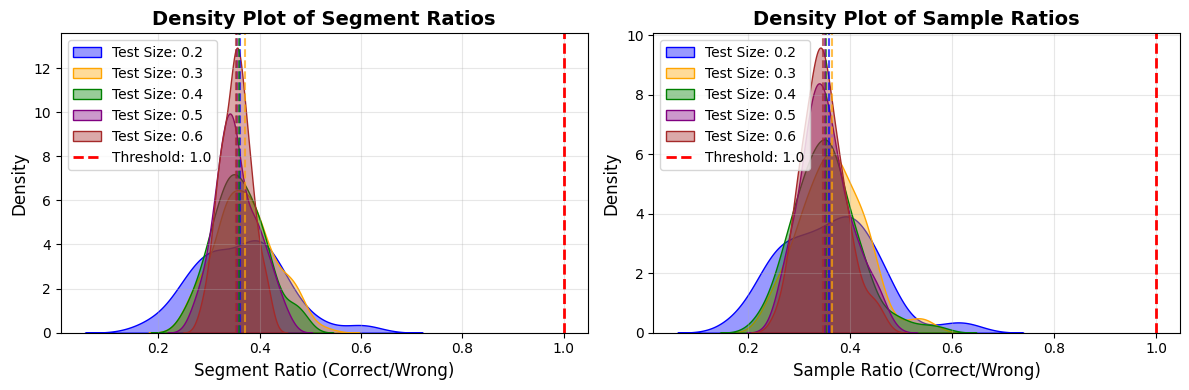

In [11]:
#------------------Testing dry bean dataset------------------
df_bean = pd.read_csv("../data/continuous/Dry_Bean_Dataset.csv")
LabelEncoder = LabelEncoder()
df_bean['Class'] = LabelEncoder.fit_transform(df_bean['Class'])
df_bean.rename(columns={'Class': 'class'}, inplace=True)
analyze_overfitting_across_test_sizes(df_bean, classifier_name="GaussianNB")


Test Size: 0.2
Average Train Accuracy: 0.9433
Average Test Accuracy: 0.9320
Average Correct Segments: 0.87
Average Wrong Segments: 1.56
Average Correct Samples: 0.90
Average Wrong Samples: 1.56
Average Segment Ratio: 0.6872
Average Sample Ratio: 0.7199
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.3
Average Train Accuracy: 0.9425
Average Test Accuracy: 0.9377
Average Correct Segments: 1.15
Average Wrong Segments: 1.91
Average Correct Samples: 1.15
Average Wrong Samples: 2.09
Average Segment Ratio: 0.7819
Average Sample Ratio: 0.7618
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.4
Average Train Accuracy: 0.9416
Average Test Accuracy: 0.9396
Average Correct Segments: 1.55
Average Wrong Segments: 2.38
Average Correct Samples: 1.73
Average Wrong Samples: 2.85
Average Segment Ratio: 0.7801
Average Sample Ratio: 0.7915


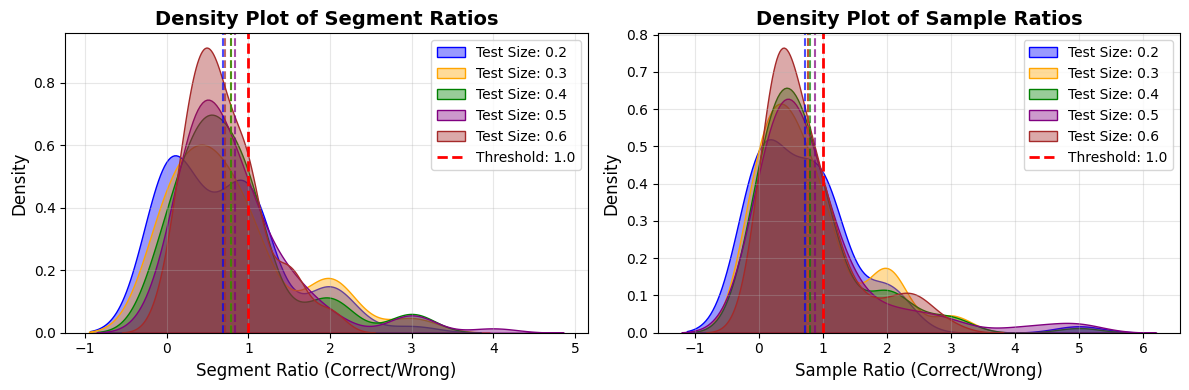

In [13]:
from sklearn.datasets import load_breast_cancer
#------------------Testing breast cancer dataset------------------
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
breast_cancer_df = pd.DataFrame(X, columns=breast_cancer.feature_names)
breast_cancer_df['class'] = y
analyze_overfitting_across_test_sizes(breast_cancer_df, classifier_name="GaussianNB")


Test Size: 0.2
Average Train Accuracy: 0.8413
Average Test Accuracy: 0.8397
Average Correct Segments: 0.74
Average Wrong Segments: 1.09
Average Correct Samples: 0.82
Average Wrong Samples: 1.15
Average Segment Ratio: 0.7059
Average Sample Ratio: 0.7941
Overfitting Analysis on Dataset (segment_wise): Overfitting
Overfitting Analysis on Dataset (sample_wise): Overfitting

Test Size: 0.3
Average Train Accuracy: 0.8415
Average Test Accuracy: 0.8421
Average Correct Segments: 1.44
Average Wrong Segments: 1.17
Average Correct Samples: 1.59
Average Wrong Samples: 1.31
Average Segment Ratio: 1.2685
Average Sample Ratio: 1.3410
Overfitting Analysis on Dataset (segment_wise): Not Overfitting
Overfitting Analysis on Dataset (sample_wise): Not Overfitting

Test Size: 0.4
Average Train Accuracy: 0.8448
Average Test Accuracy: 0.8360
Average Correct Segments: 2.02
Average Wrong Segments: 1.23
Average Correct Samples: 2.45
Average Wrong Samples: 1.32
Average Segment Ratio: 1.7803
Average Sample Ratio:

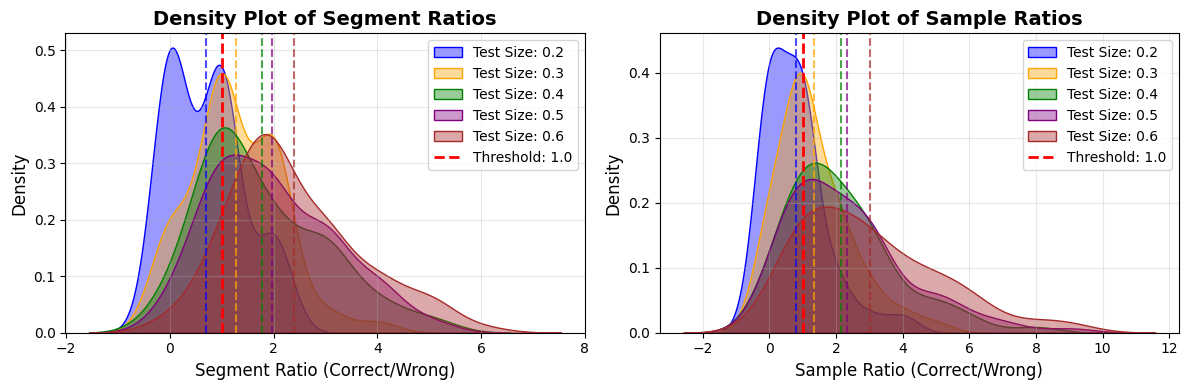

In [25]:
# testing haberman's survival dataset from UCI ML repo
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
# fetch dataset 
banknote = fetch_ucirepo(id=267)
X_banknote = banknote.data.features
y_banknote = banknote.data.targets
banknote_df = pd.concat([X_banknote, y_banknote], axis=1)
analyze_overfitting_across_test_sizes(banknote_df, classifier_name="GaussianNB")